<a href="https://colab.research.google.com/github/asrulsaid/self-driving-car/blob/master/CityScapes_%5BFCN8s%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare datasets

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/cityscapes/Dataset"

## Import some Library

In [3]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import matplotlib.pyplot as plt

## Datasets Loader

In [4]:
class CityScapes(torch.utils.data.Dataset):
  def __init__(self, image_folder_path, mask_folder_path, transform=None):
    self.image_folder_path = image_folder_path
    self.mask_folder_path = mask_folder_path
    self.transform = transform
    self.images = os.listdir(image_folder_path)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_folder_path, self.images[index])
    mask_path = os.path.join(self.mask_folder_path, self.images[index])
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [5]:
os.listdir(DATA_PATH)

['annotations_prepped_train',
 'images_prepped_train',
 'images_prepped_test',
 'annotations_prepped_test']

In [6]:
TRAIN_MASK_DIR = os.path.join(DATA_PATH, 'annotations_prepped_train')

TEST_IMG_DIR = os.path.join(DATA_PATH, 'images_prepped_test')
TEST_MASK_DIR = os.path.join(DATA_PATH, 'annotations_prepped_test')

In [7]:
data_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize(),
    ToTensorV2()
])

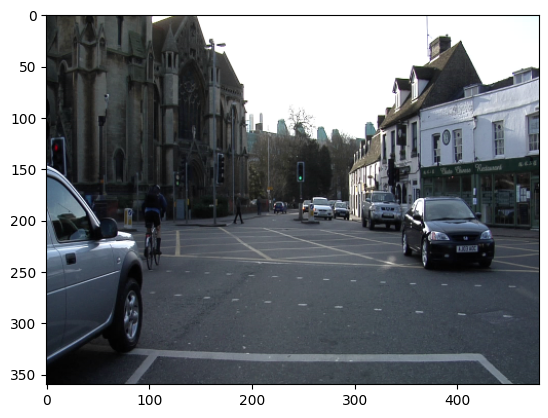

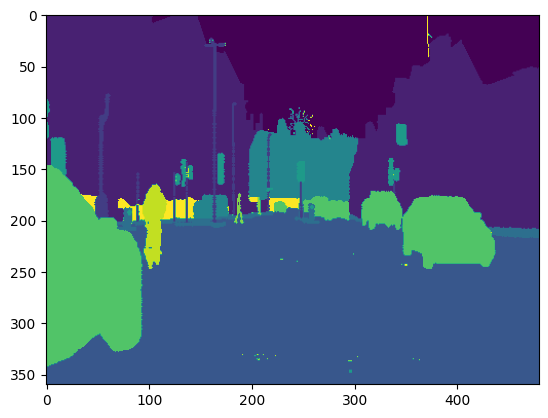

[ 0.  1.  2.  3.  4.  5.  6.  8.  9. 10. 11.]
(360, 480, 3)


In [8]:
sample = CityScapes(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
image, mask = sample[0]
plt.imshow(image)
plt.show()
plt.imshow(mask)
plt.show()

print(np.unique(mask))
print(image.shape)

In [9]:
train_dataset = CityScapes(TRAIN_IMG_DIR, TRAIN_MASK_DIR, data_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

test_dataset = CityScapes(TEST_IMG_DIR, TEST_MASK_DIR, data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

## Model Architecture

## DoubleConv

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

## UNet

In [ ]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # doblemconv, dobleconv..
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #upsam, doubleconv, up, ..
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(#0
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))#1

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reversed(skip_connections)

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# FCN8s

In [11]:
class FCN8s(nn.Module):
  def __init__(self, in_channels, out_channels, features= [64, 128, 256, 512, 1024]):
    super().__init__()
    self.layers = nn.ModuleList()
    self.pool = nn.MaxPool2d(2, 2)

    for feature in features:
      self.layers.append(DoubleConv(in_channels, feature))
      in_channels = feature

    self.ups1 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
    self.ups2 = nn.ConvTranspose2d(features[-1], features[-3], kernel_size=2, stride=2)

    self.predictions = nn.ConvTranspose2d(features[-2], out_channels, kernel_size=8, stride=8)

  def forward(self, x):
    skip_connections=[]

    for idx,layer in enumerate(self.layers):
      x = layer(x)
      x = self.pool(x)
      if idx in [2,3]:
        skip_connections.append(x)


    ups1 = self.ups1(x)
    concat1 = torch.concat([ups1, skip_connections[-1]], dim=1)

    ups2 = self.ups2(concat1)
    concat2 = torch.concat([ups2, skip_connections[-2]], dim=1)

    return self.predictions(concat2)

## Training Phase

In [ ]:
!pip install torchmetrics

In [14]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchmetrics import JaccardIndex, Dice

In [49]:
num_classes = 12
num_epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = FCN8s(in_channels=3, out_channels=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

calculate_dice = Dice(num_classes=num_classes, average='micro').to(device)
calculate_iou = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)

In [50]:
def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
  #please do training step in this function
  model.train()
  loss_one_step = 0
  loop = tqdm(dataloader)
  for data, targets in loop:
      data = data.to('cuda')
      targets = torch.as_tensor(targets, dtype=torch.int64, device=device)
      # forward
      with torch.cuda.amp.autocast():
          predictions = model(data)
          loss = criterion(predictions, targets)

      optimizer.zero_grad()
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      loss_one_step += loss.item()

      # update tqdm loop
      loop.set_postfix(loss=loss.item())

  return loss_one_step / len(dataloader)

def evaluate(model, dataloader, criterion, device):
  #please do evaluation step that calculate evaluation loss and evaluation metrics dice_score_coefficient
  model.eval()
  dice_score = 0
  iou_score = 0
  loss_one_step = 0
  loop = tqdm(dataloader)

  for data, targets in loop:
      data = data.to('cuda')
      targets = torch.as_tensor(targets, dtype=torch.int64, device=device)
      with torch.no_grad():
          with torch.cuda.amp.autocast():
              predictions = model(data)

              # Test_loss
              loss = criterion(predictions, targets)
              # Dice Score
              dice = calculate_dice(predictions, targets)
              # IoU Score
              iou = calculate_iou(predictions, targets)

      loss_one_step += loss.item()
      dice_score += dice.item()
      iou_score += iou.item()

      loop.set_postfix(loss=loss.item())

  return loss_one_step / len(dataloader), dice_score / len(dataloader), iou_score / len(dataloader)

In [51]:
def train(model, num_epochs, train_dataloader, test_dataloader, criterion, optimizer, scaler, device):
  #please init everthing in here and do the training process
  model.to(device)
  history = {"train_loss": [], "test_loss": [], "dice_loss": [],"iou_loss": []}
  for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
    train_loss = train_epoch(model, train_dataloader, criterion, optimizer, scaler, device)
    test_loss, dice_score, iou_score = evaluate(model, test_dataloader, criterion, device)

    dice_loss = 1 - dice_score
    iou_loss = 1 - iou_score

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["dice_loss"].append(dice_loss)
    history["iou_loss"].append(iou_loss)

    print("\nDice Score : ", dice_score)
    print("Loss Dice Score : ", dice_loss)
    print("IoU Score : ", iou_score)
    print("Loss IoU Score : ", iou_loss)
    print()

  return history

In [52]:
history = train(model, num_epochs, train_dataloader, test_dataloader, criterion, optimizer, scaler, device)

[INFO]: Epoch 1 of 50


100%|██████████| 7/7 [00:01<00:00,  3.73it/s, loss=2.76]



Dice Score :  0.46705148049763273
Loss Dice Score :  0.5329485195023673
IoU Score :  0.12013854405709676
Loss IoU Score :  0.8798614559429032

[INFO]: Epoch 2 of 50


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=1.75]



Dice Score :  0.6233351826667786
Loss Dice Score :  0.37666481733322144
IoU Score :  0.20634380834443228
Loss IoU Score :  0.7936561916555678

[INFO]: Epoch 3 of 50


100%|██████████| 7/7 [00:04<00:00,  1.57it/s, loss=0.787]



Dice Score :  0.7541517274720329
Loss Dice Score :  0.24584827252796715
IoU Score :  0.29571166208812166
Loss IoU Score :  0.7042883379118783

[INFO]: Epoch 4 of 50


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, loss=0.747]



Dice Score :  0.7442202397755214
Loss Dice Score :  0.25577976022447857
IoU Score :  0.2867253337587629
Loss IoU Score :  0.713274666241237

[INFO]: Epoch 5 of 50


100%|██████████| 7/7 [00:01<00:00,  4.54it/s, loss=0.646]



Dice Score :  0.7866197569029671
Loss Dice Score :  0.21338024309703285
IoU Score :  0.3317191643374307
Loss IoU Score :  0.6682808356625694

[INFO]: Epoch 6 of 50


100%|██████████| 7/7 [00:02<00:00,  3.42it/s, loss=0.588]



Dice Score :  0.8079173479761396
Loss Dice Score :  0.19208265202386043
IoU Score :  0.35153735109737944
Loss IoU Score :  0.6484626489026206

[INFO]: Epoch 7 of 50


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.418]



Dice Score :  0.853377912725721
Loss Dice Score :  0.14662208727427894
IoU Score :  0.3929969710963113
Loss IoU Score :  0.6070030289036887

[INFO]: Epoch 8 of 50


100%|██████████| 7/7 [00:02<00:00,  2.63it/s, loss=0.427]



Dice Score :  0.8527178083147321
Loss Dice Score :  0.1472821916852679
IoU Score :  0.3921956590243748
Loss IoU Score :  0.6078043409756252

[INFO]: Epoch 9 of 50


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=0.416]



Dice Score :  0.8608042342322213
Loss Dice Score :  0.1391957657677787
IoU Score :  0.41154453584126066
Loss IoU Score :  0.5884554641587394

[INFO]: Epoch 10 of 50


100%|██████████| 7/7 [00:01<00:00,  3.63it/s, loss=0.576]



Dice Score :  0.8075553093637738
Loss Dice Score :  0.19244469063622616
IoU Score :  0.3883658860410963
Loss IoU Score :  0.6116341139589037

[INFO]: Epoch 11 of 50


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.449]



Dice Score :  0.8610351255961827
Loss Dice Score :  0.13896487440381733
IoU Score :  0.3939917981624603
Loss IoU Score :  0.6060082018375397

[INFO]: Epoch 12 of 50


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, loss=0.415]



Dice Score :  0.8641519291060311
Loss Dice Score :  0.1358480708939689
IoU Score :  0.4020916904721941
Loss IoU Score :  0.5979083095278059

[INFO]: Epoch 13 of 50


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, loss=0.453]



Dice Score :  0.8383092028754098
Loss Dice Score :  0.16169079712459022
IoU Score :  0.4155907503196171
Loss IoU Score :  0.5844092496803829

[INFO]: Epoch 14 of 50


100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.421]



Dice Score :  0.8469184637069702
Loss Dice Score :  0.15308153629302979
IoU Score :  0.41490536502429415
Loss IoU Score :  0.5850946349757058

[INFO]: Epoch 15 of 50


100%|██████████| 7/7 [00:02<00:00,  2.66it/s, loss=0.446]



Dice Score :  0.8431485891342163
Loss Dice Score :  0.1568514108657837
IoU Score :  0.41459772842270987
Loss IoU Score :  0.5854022715772902

[INFO]: Epoch 16 of 50


100%|██████████| 7/7 [00:01<00:00,  4.42it/s, loss=0.31]



Dice Score :  0.8935161318097796
Loss Dice Score :  0.10648386819022038
IoU Score :  0.48326732431139263
Loss IoU Score :  0.5167326756886074

[INFO]: Epoch 17 of 50


100%|██████████| 7/7 [00:02<00:00,  3.05it/s, loss=0.36]



Dice Score :  0.8705801282610212
Loss Dice Score :  0.12941987173897884
IoU Score :  0.4459651495729174
Loss IoU Score :  0.5540348504270827

[INFO]: Epoch 18 of 50


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, loss=0.34]



Dice Score :  0.8859878267560687
Loss Dice Score :  0.11401217324393131
IoU Score :  0.47447313581194195
Loss IoU Score :  0.525526864188058

[INFO]: Epoch 19 of 50


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=0.347]



Dice Score :  0.8762379799570356
Loss Dice Score :  0.12376202004296444
IoU Score :  0.5188919986997332
Loss IoU Score :  0.48110800130026676

[INFO]: Epoch 20 of 50


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.363]



Dice Score :  0.8766102961131504
Loss Dice Score :  0.12338970388684956
IoU Score :  0.5263640539986747
Loss IoU Score :  0.4736359460013253

[INFO]: Epoch 21 of 50


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.326]



Dice Score :  0.885080771786826
Loss Dice Score :  0.11491922821317402
IoU Score :  0.49303944196019855
Loss IoU Score :  0.5069605580398014

[INFO]: Epoch 22 of 50


100%|██████████| 7/7 [00:01<00:00,  3.51it/s, loss=0.521]



Dice Score :  0.8087272644042969
Loss Dice Score :  0.19127273559570312
IoU Score :  0.43460207751819063
Loss IoU Score :  0.5653979224818093

[INFO]: Epoch 23 of 50


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.452]



Dice Score :  0.8421165772846767
Loss Dice Score :  0.1578834227153233
IoU Score :  0.46490368247032166
Loss IoU Score :  0.5350963175296783

[INFO]: Epoch 24 of 50


100%|██████████| 7/7 [00:02<00:00,  2.53it/s, loss=0.314]



Dice Score :  0.8866231100899833
Loss Dice Score :  0.11337688991001671
IoU Score :  0.49624199100903105
Loss IoU Score :  0.503758008990969

[INFO]: Epoch 25 of 50


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, loss=0.337]



Dice Score :  0.8732395172119141
Loss Dice Score :  0.12676048278808594
IoU Score :  0.482903961624418
Loss IoU Score :  0.517096038375582

[INFO]: Epoch 26 of 50


100%|██████████| 7/7 [00:01<00:00,  3.75it/s, loss=0.33]



Dice Score :  0.8866145014762878
Loss Dice Score :  0.11338549852371216
IoU Score :  0.5291877729552132
Loss IoU Score :  0.47081222704478676

[INFO]: Epoch 27 of 50


100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.367]



Dice Score :  0.870200480733599
Loss Dice Score :  0.129799519266401
IoU Score :  0.49781722256115507
Loss IoU Score :  0.502182777438845

[INFO]: Epoch 28 of 50


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.316]



Dice Score :  0.8903193899563381
Loss Dice Score :  0.10968061004366192
IoU Score :  0.48684512291635784
Loss IoU Score :  0.5131548770836422

[INFO]: Epoch 29 of 50


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=0.337]



Dice Score :  0.8913095763751439
Loss Dice Score :  0.10869042362485615
IoU Score :  0.54112195117133
Loss IoU Score :  0.45887804882867

[INFO]: Epoch 30 of 50


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, loss=0.285]



Dice Score :  0.8995764085224697
Loss Dice Score :  0.10042359147753033
IoU Score :  0.5504764233316694
Loss IoU Score :  0.44952357666833065

[INFO]: Epoch 31 of 50


100%|██████████| 7/7 [00:02<00:00,  3.33it/s, loss=0.305]



Dice Score :  0.8995403051376343
Loss Dice Score :  0.10045969486236572
IoU Score :  0.5592067241668701
Loss IoU Score :  0.4407932758331299

[INFO]: Epoch 32 of 50


100%|██████████| 7/7 [00:01<00:00,  4.50it/s, loss=0.277]



Dice Score :  0.9015632101467678
Loss Dice Score :  0.09843678985323223
IoU Score :  0.5519236411367144
Loss IoU Score :  0.44807635886328556

[INFO]: Epoch 33 of 50


100%|██████████| 7/7 [00:02<00:00,  2.70it/s, loss=0.316]



Dice Score :  0.8889191491263253
Loss Dice Score :  0.1110808508736747
IoU Score :  0.5326840707233974
Loss IoU Score :  0.4673159292766026

[INFO]: Epoch 34 of 50


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, loss=0.311]



Dice Score :  0.8984003577913556
Loss Dice Score :  0.10159964220864437
IoU Score :  0.5686576792172023
Loss IoU Score :  0.43134232078279766

[INFO]: Epoch 35 of 50


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, loss=0.318]



Dice Score :  0.8850291967391968
Loss Dice Score :  0.11497080326080322
IoU Score :  0.5256133079528809
Loss IoU Score :  0.47438669204711914

[INFO]: Epoch 36 of 50


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, loss=0.297]



Dice Score :  0.8947460991995675
Loss Dice Score :  0.10525390080043251
IoU Score :  0.5531109571456909
Loss IoU Score :  0.4468890428543091

[INFO]: Epoch 37 of 50


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, loss=0.304]



Dice Score :  0.8912242310387748
Loss Dice Score :  0.1087757689612252
IoU Score :  0.5285020811217171
Loss IoU Score :  0.47149791887828285

[INFO]: Epoch 38 of 50


100%|██████████| 7/7 [00:02<00:00,  3.11it/s, loss=0.302]



Dice Score :  0.8960431218147278
Loss Dice Score :  0.10395687818527222
IoU Score :  0.5399052926472255
Loss IoU Score :  0.46009470735277447

[INFO]: Epoch 39 of 50


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.302]



Dice Score :  0.896972520010812
Loss Dice Score :  0.10302747998918804
IoU Score :  0.5534517765045166
Loss IoU Score :  0.4465482234954834

[INFO]: Epoch 40 of 50


100%|██████████| 7/7 [00:02<00:00,  2.68it/s, loss=0.301]



Dice Score :  0.8982355424336025
Loss Dice Score :  0.10176445756639751
IoU Score :  0.565345994063786
Loss IoU Score :  0.43465400593621395

[INFO]: Epoch 41 of 50


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, loss=0.297]



Dice Score :  0.8925191845212664
Loss Dice Score :  0.10748081547873356
IoU Score :  0.5309021728379386
Loss IoU Score :  0.4690978271620614

[INFO]: Epoch 42 of 50


100%|██████████| 7/7 [00:01<00:00,  4.41it/s, loss=0.333]



Dice Score :  0.8813650948660714
Loss Dice Score :  0.1186349051339286
IoU Score :  0.531739354133606
Loss IoU Score :  0.46826064586639404

[INFO]: Epoch 43 of 50


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.312]



Dice Score :  0.8973913448197501
Loss Dice Score :  0.10260865518024986
IoU Score :  0.5557593277522496
Loss IoU Score :  0.44424067224775043

[INFO]: Epoch 44 of 50


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, loss=0.314]



Dice Score :  0.897591369492667
Loss Dice Score :  0.10240863050733295
IoU Score :  0.5531583002635411
Loss IoU Score :  0.44684169973645893

[INFO]: Epoch 45 of 50


100%|██████████| 7/7 [00:01<00:00,  3.87it/s, loss=0.29]



Dice Score :  0.9015725255012512
Loss Dice Score :  0.09842747449874878
IoU Score :  0.5753402028764997
Loss IoU Score :  0.4246597971235003

[INFO]: Epoch 46 of 50


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=0.312]



Dice Score :  0.8976882100105286
Loss Dice Score :  0.10231178998947144
IoU Score :  0.5474909458841596
Loss IoU Score :  0.4525090541158404

[INFO]: Epoch 47 of 50


100%|██████████| 7/7 [00:02<00:00,  2.76it/s, loss=0.319]



Dice Score :  0.8975817561149597
Loss Dice Score :  0.10241824388504028
IoU Score :  0.5490409646715436
Loss IoU Score :  0.4509590353284564

[INFO]: Epoch 48 of 50


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.331]



Dice Score :  0.9004751784460885
Loss Dice Score :  0.09952482155391151
IoU Score :  0.5628166709627423
Loss IoU Score :  0.43718332903725765

[INFO]: Epoch 49 of 50


100%|██████████| 7/7 [00:02<00:00,  3.33it/s, loss=0.335]



Dice Score :  0.9002166731016976
Loss Dice Score :  0.09978332689830238
IoU Score :  0.5640847768102374
Loss IoU Score :  0.4359152231897626

[INFO]: Epoch 50 of 50


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, loss=0.313]


Dice Score :  0.9028223838124957
Loss Dice Score :  0.09717761618750431
IoU Score :  0.5614097033228193
Loss IoU Score :  0.43859029667718075



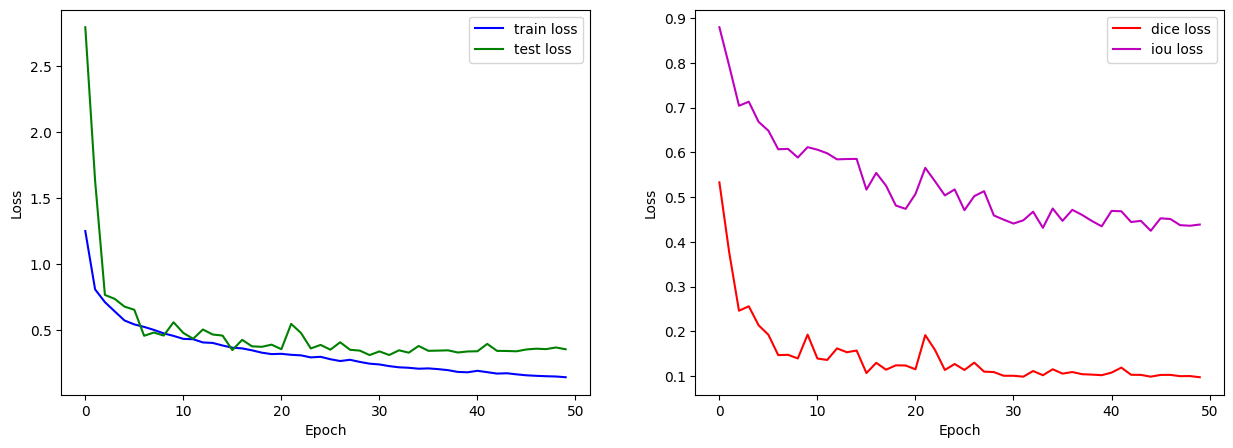

In [80]:
# Visualizing the Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history['train_loss'], color='b', label='train loss')
ax[0].plot(history['test_loss'], color='g', label='test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history['dice_loss'], color='r', label='dice loss')
ax[1].plot(history['iou_loss'], color='m', label='iou loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

# plt.savefig('accuracy.png')
plt.show()

# Test Inference

In [62]:
def inference(tensor):
  model.eval()
  with torch.no_grad():
    tensor = torch.unsqueeze(tensor, dim=0).to('cuda')
    result = model(tensor)
    softmax = nn.Softmax(dim=1)
    result = torch.argmax(softmax(result),axis=1).to('cpu')

  return result

def img_to_numpy(tensor):
  tensor = torch.squeeze(tensor)
  tensor = tensor.cpu().detach().numpy()
  return tensor

def inverse_transform(img):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = img_to_numpy(img).transpose((1,2,0))
  img = (img * std+mean)
  img = np.clip(img,0,1)
  return img

def plot_inference(idx, dataset):
  img, targets = dataset[idx]
  result = inference(img)
  inv_img = inverse_transform(img)

  fig, ax = plt.subplots(1, 3, figsize=(18, 18))
  ax[0].imshow(inv_img)
  ax[0].set_title('Image')
  ax[0].axis('off')

  ax[1].imshow(targets)
  ax[1].set_title('Target')
  ax[1].axis('off')

  ax[2].imshow(img_to_numpy(result))
  ax[2].set_title('Prediction')
  ax[2].axis('off')

  plt.show()

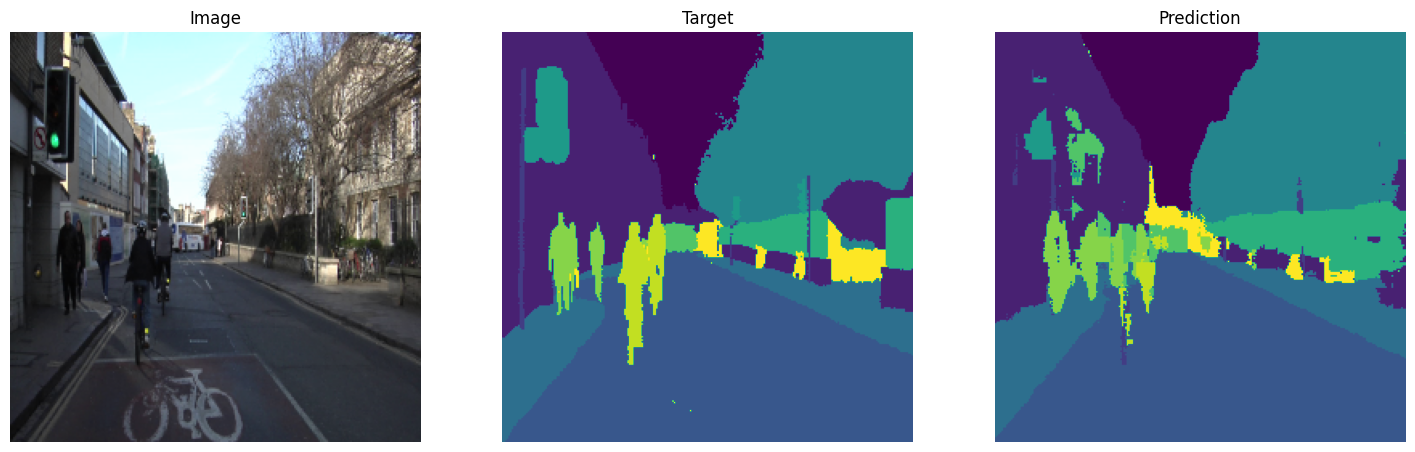

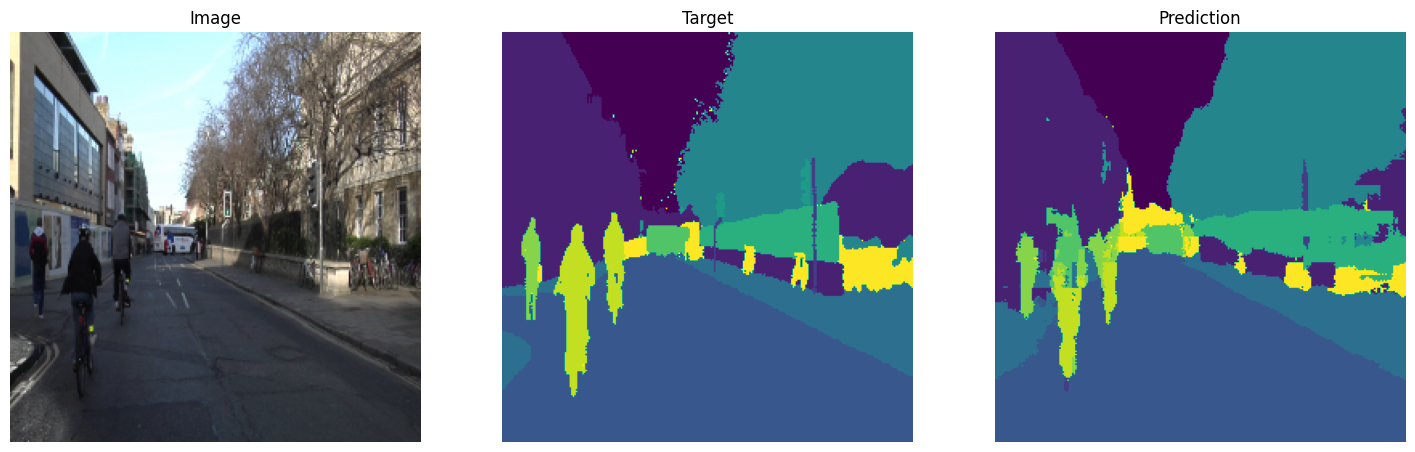

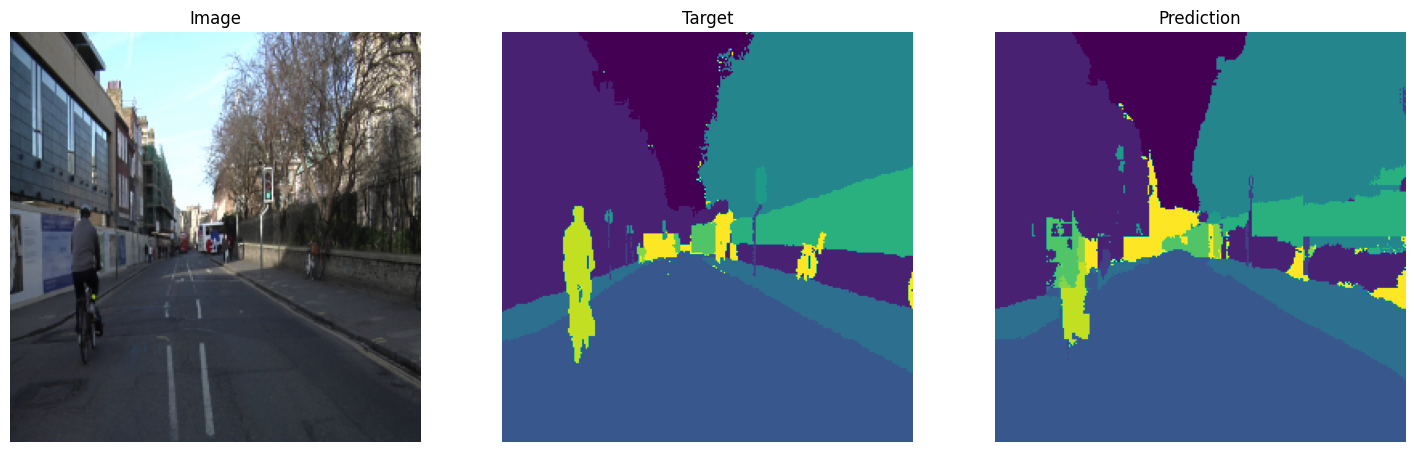

In [63]:
get_img = 3 #inference 3 img

for idx in range(get_img):
  plot_inference(idx, test_dataset)